In [2]:
'''
Author: Rory Speirs
Institution (at time of work): Joint Quantum Institute, The University of Maryland
Email: roryspeirs@gmail.com
'''

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.signal import filtfilt
import pickle 

pi = np.pi
############################################################################################

def fftfreq_easy(t):
    f = np.fft.fftfreq(len(t), (t[1]-t[0]))
    return f

def find_nearest(array,value):
    idx = (abs(array-value)).argmin()
    actual_val = array[idx]
    return idx, actual_val

def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero*10E-10
    return data

def amp_to_dB(amp, ref_amp):
    dB = 10*np.log10(amp**2/ref_amp**2)
    return dB

def amp_given_dB_change(old_amp, power_change_dB):
    new_amp = old_amp*np.sqrt(10**(power_change_dB/10))
    return new_amp

def normed_dB_t(signal_t):
    signal_nu = np.fft.fftshift(np.fft.fft(signal_t, norm = 'ortho'))
    power = abs(signal_nu)**2
    power_ratio = power/power.max()
    power_ratio = replaceZeroes(power_ratio)
    dB_power_ratio = 10*np.log10(power_ratio)
    return dB_power_ratio

def normed_dB_nu(signal_nu):
    signal_nu = np.fft.fftshift(signal_nu)
    power = abs(signal_nu)**2
    power_ratio = power/power.max()
    power_ratio = replaceZeroes(power_ratio)
    dB_power_ratio = 10*np.log10(power_ratio)
    return dB_power_ratio

def constrain_time_domain(signal_t, constraints):
    phase_t = np.unwrap(np.angle(signal_t))

    #centring and clipping (throwing away out of range stuff)
    phase_range = phase_t.max() - phase_t.min()
    phase_t = phase_t - phase_t.min() - phase_range/2
    allowed_range = constraints['allowable_phase_range']
    phase_t[phase_t>allowed_range/2] = allowed_range/2
    phase_t[phase_t<-allowed_range/2] = -allowed_range/2

    # filtering
    start_idx = len(phase_t)
    end_idx = 2*start_idx
    phase_t_extended = np.concatenate((phase_t, phase_t, phase_t))
    phase_t_extended = filtfilt(constraints['time_domain_phase_filter_parameter_0'], constraints['time_domain_phase_filter_parameter_1'], phase_t_extended)  #GOOD, because it compensates for the phase shift.
    phase_t = phase_t_extended[start_idx:end_idx]

    #constraining time domain amplitude to be constant
    signal_t_constrained  = 1.0*np.exp(1j*phase_t)
    return signal_t_constrained

def constrain_frequency_domain(signal_nu, constraints):
    phase_nu = np.angle(signal_nu)
    amp_nu = abs(signal_nu)
    
    ################################################################################################
    '''Amplitude constraints:
        1. Decay values toward desired level (usually toward 0)
        2. Apply limiting constraints (conditional constraints)
        3. Apply direct constraints. (Set values exactly)
    '''
    amp_nu = amp_nu/amp_nu.max() #normalise the amplitude to the peak of the carrier. This makes constraints easier to apply

    #Decay constraints
    amp_nu[constraints['amplitude']['decay']['idxs']] = amp_nu[constraints['amplitude']['decay']['idxs']]*constraints['amplitude']['decay']['vals']

    #conditional constraint (reduce components below their max)
    amp_nu_sub_array = amp_nu[constraints['amplitude']['conditional_upper']['idxs']]
    max_amp_violation_idxs = amp_nu_sub_array > constraints['amplitude']['conditional_upper']['vals']
    amp_nu_sub_array[max_amp_violation_idxs] = constraints['amplitude']['conditional_upper']['vals'][max_amp_violation_idxs]
    amp_nu[constraints['amplitude']['conditional_upper']['idxs']] = amp_nu_sub_array[:]
    #conditional constraint (increase components above their min)
    amp_nu_sub_array = amp_nu[constraints['amplitude']['conditional_lower']['idxs']]
    min_amp_violation_idxs = amp_nu_sub_array < constraints['amplitude']['conditional_lower']['vals']
    amp_nu_sub_array[min_amp_violation_idxs] = constraints['amplitude']['conditional_lower']['vals'][min_amp_violation_idxs]
    amp_nu[constraints['amplitude']['conditional_lower']['idxs']] = amp_nu_sub_array[:]

    #absolute constraint
    amp_nu[constraints['amplitude']['absolute']['idxs']] = constraints['amplitude']['absolute']['vals']

    ################################################################################################
    '''Phase constraints:
        1. Decay values toward desired level (usually toward 0) NOT IMPLEMENTED
        2. Apply limiting constraints (conditional constraints)
        3. Apply direct constraints. (Set values exactly)
    '''
    #Decay constraints not imposed

    #conditional constraint (reduce components below their max)
    phase_nu_sub_array = phase_nu[constraints['phase']['conditional_upper']['idxs']]
    max_phase_violation_idxs = phase_nu_sub_array > constraints['phase']['conditional_upper']['vals']
    phase_nu_sub_array[max_phase_violation_idxs] = constraints['phase']['conditional_upper']['vals'][max_phase_violation_idxs]
    phase_nu[constraints['phase']['conditional_upper']['idxs']] = phase_nu_sub_array[:]
    #conditional constraint (increase components above their min)
    phase_nu_sub_array = phase_nu[constraints['phase']['conditional_lower']['idxs']]
    min_phase_violation_idxs = phase_nu_sub_array < constraints['phase']['conditional_lower']['vals']
    phase_nu_sub_array[min_phase_violation_idxs] = constraints['phase']['conditional_lower']['vals'][min_phase_violation_idxs]
    phase_nu[constraints['phase']['conditional_lower']['idxs']] = phase_nu_sub_array[:]

    #absolute constraint
    phase_nu[constraints['phase']['absolute']['idxs']] = constraints['phase']['absolute']['vals']
 
    signal_nu_constrained = amp_nu*np.exp(1j*phase_nu)
    #Normalise
    signal_nu_constrained = signal_nu_constrained/np.sqrt((abs(signal_nu_constrained)**2).sum())
    return signal_nu_constrained

def plot_achieved_results(data_file_name):
    with open(data_file_name, 'rb') as f:
        data = pickle.load(f)

    t = data['t']
    nu = data['nu']
    sample_rate = data['sample_rate']
    sideband_nu = sample_rate/t.size
    nu_ordered = np.fft.fftshift(nu)

    env_t = data['env_t']
    phase_t = data['phase_t']
    constraints_time_domain0 = data['constraints_time_domain']
    constraints_frequency_domain = data['constraints_frequency_domain']

    import matplotlib.gridspec as gridspec
    matplotlib.rcParams['font.size'] = 9

    fig = plt.figure(figsize=(8.5/2.54 ,1.5*10/2.54))
    ax0 = fig.add_subplot(3, 1, 1)
    ax1 = fig.add_subplot(3, 1, 2)
    ax2 = fig.add_subplot(3, 1, 3)

    # Plot sideband amplitude
    ax0.plot(1E-6*nu[constraints_frequency_domain['amplitude']['absolute']['idxs']], amp_to_dB(constraints_frequency_domain['amplitude']['absolute']['vals'], 1), 'C3o', markersize=6, label='exactly set')
    ax0.plot(nu_ordered*1E-6, normed_dB_t(env_t), 'C0-o', markersize=2, label=r'0') 
    ax0.set_xlim(-25, 25)
    ax0.set_ylim(-50, 5)
    ax0.set_xlabel(r'$\nu$ (MHz)', fontsize=9)
    ax0.set_ylabel(r'$|\breve{\mathcal{E}}(\nu)|^2$ (dB)', fontsize=9)

    # Plot sideband phase
    env_nu = np.fft.fftshift(np.fft.fft(env_t, norm='ortho'))
    ax1.plot(1E-6*nu[constraints_frequency_domain['phase']['absolute']['idxs']], constraints_frequency_domain['phase']['absolute']['vals'], 'C3o', markersize=6, label='exactly set')
    ax1.plot(nu_ordered*1E-6, np.angle(env_nu), 'C2o', markersize=2, label=r'0')
    ax1.plot(nu_ordered*1E-6, np.zeros(nu_ordered.size), 'C2-', markersize=2, label=r'0', alpha=0.3)
    for nu_val, env_nu_val in zip(nu_ordered, env_nu):
        ax1.plot([nu_val*1E-6, nu_val*1E-6], [0, np.angle(env_nu_val)], 'C2-', markersize=2, label=r'0', alpha=0.3)
    ax1.set_xlim(-25, 25)
    ax1.set_ylim(-pi*1.1, pi*1.1)
    ax1.set_yticks([-pi, -pi/2, 0, pi/2, pi])
    ax1.set_yticklabels((r'$-\pi$', r'$-\dfrac{\pi}{2}$', r'$0$', r'$\dfrac{\pi}{2}$', r'$\pi$'))
    ax1.set_ylabel(r'$\theta(\nu)$ (rad)', fontsize=9)
    ax1.set_xlabel(r'$\nu$ (MHz)', fontsize=9)

    # Plot time domain phase (Signal to feed to the EOM)
    ax2.plot(t*1E6, phase_t, 'C0', label='phase')
    ax2.set_xlim(0, t[-1]*1E6)
    ax2.set_yticks([-2*pi, -3*pi/2, -pi, -pi/2, 0, pi/2, pi, 3*pi/2, 2*pi])
    ax2.set_yticklabels((r'$-2\pi$', r'$\dfrac{-3\pi}{2}$', r'$-\pi$', r'$\dfrac{-\pi}{2}$', r'$0$', r'$\dfrac{\pi}{2}$', r'$\pi$', r'$\dfrac{3\pi}{2}$', r'$2\pi$'))
    ax2.set_xlabel(r'time ($\mu s$)', fontsize=9)
    ax2.set_ylabel(r'$\phi(t)$ (rad)', fontsize=9)
    ax2.grid(axis='y')

    fig.tight_layout()
    # fig.savefig('arb_sideband_result.pdf')
    plt.show()



#####################################################################################################
def make_constraints_frequency_domain(nu, sideband_nu):
    '''
    Choose how the sidebands in the frequency domain are constrained.
    There are six types of constraints in total.
    Amplitude constraints:
        1. Absolute constraints - Set any sidebands that you want to a specific power
        2. Conditional constraints - Set any sidebands that you want to have an upper allowable 
            and/or lower alloweable power level.
            Upper and lower levels are set independently for any sidebands.
        3. Decay amplidtude constraints - Amplitudes of sidebands are multiplied by a frequency
            dependednt function. This is usually used to decay sidebands at high frequency.

    Phase constraints:
        1. Absolute constraints - Set any sidebands that you want to a specific phase. 
            This is probably the only constraint needed for most people.
        2. Conditional constraints - Set any sidebands that you want to have an upper allowable 
            and/or lower allowable phase.
            Upper and lower levels are set independently for any sidebands.
        3. Decay Phase constraints - In principle, you can try nudging phases to a particular
            value each time. But I couldn't think of a good reason to do this, and while there
            is a dictionary constraint for it, the constraint is not currently implemented in
            this code.
        
    '''
    constraints = {'amplitude':{}, 'phase':{}}

    # Absolute Amplitude Constraints
    #################################################################################################
    '''
    Fill the list with tuples of (sideband_number, power_in_dB)
    A power_in_dB of 0 corresponds to and amplidude of 1. Sideband of 0 is the carrier.
    '''
    # frequency_power_pairs = [] # Make empty list if no constraints required
    frequency_power_pairs = [   (0, 0),
                                (1, 0),
                                (2, -6),
                                (3, -12),
                                (4, -18),
                                (5, -24),
                                (6, -30),
                                (7, -24),
                                (8, -18),
                                (9, -12),
                                (10, -6),
                                (-1, -30),
                                (-2, -14),
                                (-3, -6),
                                (-4, -2),
                                (-5, 0),
                                (-6, -2),
                                (-7, -6),
                                (-8, -14),
                                (-9, -30),
                                (-10, -14)]

    absolute_constraint, absolute_constraint_idxs = [], []
    for (sideband, power) in frequency_power_pairs:
        sideband_idx, trash = find_nearest(nu, sideband*sideband_nu)
        absolute_constraint_idxs.append(sideband_idx)
        absolute_constraint.append(amp_given_dB_change(1, power))

    constraints['amplitude']['absolute'] = {'vals':np.array(absolute_constraint), 'idxs':np.array(absolute_constraint_idxs, dtype='int')}

    # Conditional Amplitude Constraints
    #################################################################################################
    # max limiting value for everything that isn't exactly set
    upper_conditional_constraint_idxs = list(range(nu.size))
    upper_conditional_constraint = np.ones(nu.size)*amp_given_dB_change(1, -5) #This means everything is limited to an optical power 5dB below a component with amplitude 1.
    #The lower power limit for given frequencies
    lower_conditional_constraint_idxs = []
    lower_conditional_constraint = []

    constraints['amplitude']['conditional_lower'] = {'vals':np.array(lower_conditional_constraint), 'idxs':np.array(lower_conditional_constraint_idxs, dtype='int')}
    constraints['amplitude']['conditional_upper'] = {'vals':np.array(upper_conditional_constraint), 'idxs':np.array(upper_conditional_constraint_idxs, dtype='int')}

    # Decay Amplitude Constraints
    #################################################################################################
    '''This is a good leaver to pull on. A lower sigma imposes a higher cost on high frequency compnenets'''
    sigma_nu = 1000E6
    decay_coefficients = np.exp(-nu**2/(2*sigma_nu**2))
    decay_constraints_idxs = np.arange(nu.size, dtype='int')
    constraints['amplitude']['decay'] = {'vals':decay_coefficients, 'idxs':decay_constraints_idxs}

    # Absolute Phase Constraints
    #################################################################################################
    # frequency_phase_pairs = [] # Make empty list if no constraints required
    frequency_phase_pairs = [   (0, 0),
                                (1, -4*pi/4),
                                (2, -1*pi/4),
                                (3, 1*pi/4),
                                (4, 2*pi/4),
                                (5, 2.5*pi/4),
                                (6, 2*pi/4),
                                (7, 1*pi/4),
                                (8, -1*pi/4),
                                (9, -4*pi/4),
                                (10, 0*pi/4),
                                (-1, 0*pi/4),
                                (-2, 0*pi/4),
                                (-3, -3*pi/4),
                                (-4, -3*pi/4),
                                (-5, 3*pi/4),
                                (-6, 3*pi/4),
                                (-7, -3*pi/4),
                                (-8, -3*pi/4),
                                (-9, 0*pi/4),
                                (-10, 0*pi/4)]

    absolute_constraint_phi, absolute_constraint_phi_idxs = [], []
    for (sideband, phase) in frequency_phase_pairs:
        sideband_idx, trash = find_nearest(nu, sideband*sideband_nu)
        absolute_constraint_phi_idxs.append(sideband_idx)
        absolute_constraint_phi.append(phase)

    constraints['phase']['absolute'] = {'vals':np.array(absolute_constraint_phi), 'idxs':np.array(absolute_constraint_phi_idxs, dtype='int')}

    # Conditional Phase Constraints
    #################################################################################################
    constraints['phase']['conditional_lower'] = {'vals':np.array([]), 'idxs':np.array([], dtype='int')}
    constraints['phase']['conditional_upper'] = {'vals':np.array([]), 'idxs':np.array([], dtype='int')}

    # Decay Phase Constraints
    #################################################################################################
    constraints['phase']['decay'] = {'vals':np.array([]), 'idxs':np.array([], dtype='int')}

    #################################################################################################
    #remove conditional constraints from positions where absolute constraints are set
    trash, idx_to_delete, trash  = np.intersect1d(constraints['amplitude']['conditional_upper']['idxs'], constraints['amplitude']['absolute']['idxs'], return_indices=True)
    constraints['amplitude']['conditional_upper']['idxs'] = np.delete(constraints['amplitude']['conditional_upper']['idxs'], idx_to_delete)
    constraints['amplitude']['conditional_upper']['vals'] = np.delete(constraints['amplitude']['conditional_upper']['vals'], idx_to_delete)
    trash, idx_to_delete, trash  = np.intersect1d(constraints['amplitude']['conditional_lower']['idxs'], constraints['amplitude']['absolute']['idxs'], return_indices=True)
    constraints['amplitude']['conditional_lower']['idxs'] = np.delete(constraints['amplitude']['conditional_lower']['idxs'], idx_to_delete)
    constraints['amplitude']['conditional_lower']['vals'] = np.delete(constraints['amplitude']['conditional_lower']['vals'], idx_to_delete)
    trash, idx_to_delete, trash  = np.intersect1d(constraints['phase']['conditional_upper']['idxs'], constraints['phase']['absolute']['idxs'], return_indices=True)
    constraints['phase']['conditional_upper']['idxs'] = np.delete(constraints['phase']['conditional_upper']['idxs'], idx_to_delete)
    constraints['phase']['conditional_upper']['vals'] = np.delete(constraints['phase']['conditional_upper']['vals'], idx_to_delete)
    trash, idx_to_delete, trash  = np.intersect1d(constraints['phase']['conditional_lower']['idxs'], constraints['phase']['absolute']['idxs'], return_indices=True)
    constraints['phase']['conditional_lower']['idxs'] = np.delete(constraints['phase']['conditional_lower']['idxs'], idx_to_delete)
    constraints['phase']['conditional_lower']['vals'] = np.delete(constraints['phase']['conditional_lower']['vals'], idx_to_delete)
    return constraints

def make_constraints_time_domain(sample_rate):
    # allowable_phase_range is the maximum retardation that the EOM and driving electronics can achieve
    allowable_phase_range = 3*pi
 
    # Filtering. This filter should reflect the achievable bandwidth properties of the EOM and driving electronics
    cutoff = 200E6
    order = 6

    from scipy.signal import butter
    nyq = 0.5 * sample_rate
    normalised_cutoff = cutoff / nyq
    filter_parameter_0, filter_parameter_1 = butter(order, normalised_cutoff, btype='low', analog=False)

    constraints = {'allowable_phase_range':allowable_phase_range, 'time_domain_phase_filter_parameter_0':filter_parameter_0, 'time_domain_phase_filter_parameter_1':filter_parameter_1}
    return constraints

def phase_finder(data_file_name):
    #specify the sample rate and the points per cycle
    sample_rate = 4e9  
    samples_per_cycle = 2**14

    dt = 1/sample_rate
    cycle_period = samples_per_cycle/sample_rate
    sideband_nu = sample_rate/samples_per_cycle
    t = np.linspace(0, cycle_period-dt, samples_per_cycle)
    nu = fftfreq_easy(t)

    print(f'total_cycle_time = {cycle_period*1E6}μs')
    print(f'Sideband ν = {sideband_nu*1E-6}MHz')

    constraints_frequency_domain = make_constraints_frequency_domain(nu, sideband_nu)
    constraints_time_domain = make_constraints_time_domain(sample_rate)

    Env_guess = np.exp(1j*2*pi*np.random.rand(t.size)*0.01)
    env_t_constrained = Env_guess

    iterations = 2**14# 2**17 (130,000 1min), 2**19 (524,000 4:30min), 2**21 (2,000,000 18:00min)
    start_time = time.time()
    for loop in range(iterations): 
        #forward propagate
        env_nu = np.fft.fft(env_t_constrained, norm = 'ortho')
        #constrain frequency domain signal
        env_nu_constrained = constrain_frequency_domain(env_nu, constraints_frequency_domain)
        #back propagate
        env_t = np.fft.ifft(env_nu_constrained, norm = 'ortho')
        #constrain time domain signal
        env_t_constrained = constrain_time_domain(env_t, constraints_time_domain)

        if np.mod(np.log2(loop+1),1) == 0:
            print('loop:' + str(loop))

    print('Calculation time = ' + time.strftime('%H:%M:%S', time.gmtime(time.time()-start_time)))

    phase_t = np.unwrap(np.angle(env_t_constrained))
    phase_t = phase_t - (phase_t.min() + phase_t.max())/2

    results = { 'sample_rate':sample_rate,
                'samples_per_cycle':samples_per_cycle,
                't':t,
                'nu':nu,
                'env_t':env_t_constrained,
                'phase_t':phase_t,
                'constraints_frequency_domain':constraints_frequency_domain,
                'constraints_time_domain':constraints_time_domain
                }


    with open(data_file_name, 'wb') as f:
        pickle.dump(results, f)

In [3]:
def make_constraints_frequency_domain(nu, sideband_nu):
    """
    Frequency-domain constraints for 3 tones:
        Carrier (0 Hz)
        +800 MHz
        -1300 MHz
    Power ratio: 3:5:1 (upper:carrier:lower)
    """

    constraints = {'amplitude':{}, 'phase':{}}

    # --- Define target power (in linear, relative units) ---
    powers = {'carrier':5.0, '+800MHz':3.0, '-1300MHz':1.0}
    amps = {k: np.sqrt(v) for k, v in powers.items()}

    # --- Map to sideband indices ---
    # Compute corresponding frequency indices
    idx_carrier, _ = find_nearest(nu, 0.0)
    idx_upper, _   = find_nearest(nu, +800e6)
    idx_lower, _   = find_nearest(nu, -1300e6)

    # --- Absolute amplitude constraints ---
    absolute_constraint_idxs = np.array([idx_carrier, idx_upper, idx_lower], dtype=int)
    absolute_constraint_vals = np.array([amps['carrier'], amps['+800MHz'], amps['-1300MHz']])

    constraints['amplitude']['absolute'] = {
        'vals': absolute_constraint_vals,
        'idxs': absolute_constraint_idxs
    }

    # --- Conditional amplitude constraints (soft upper limit elsewhere) ---
    upper_conditional_constraint_idxs = np.arange(nu.size)
    upper_conditional_constraint = np.ones(nu.size) * amp_given_dB_change(1, -30)  # -30 dB
    lower_conditional_constraint_idxs, lower_conditional_constraint = [], []

    constraints['amplitude']['conditional_lower'] = {
        'vals': np.array(lower_conditional_constraint),
        'idxs': np.array(lower_conditional_constraint_idxs, dtype=int)
    }
    constraints['amplitude']['conditional_upper'] = {
        'vals': upper_conditional_constraint,
        'idxs': upper_conditional_constraint_idxs
    }

    # --- Decay amplitude constraints (suppress far-away junk) ---
    sigma_nu = 2.0e9
    decay_coefficients = np.exp(-nu**2 / (2 * sigma_nu**2))
    decay_constraints_idxs = np.arange(nu.size, dtype=int)
    constraints['amplitude']['decay'] = {
        'vals': decay_coefficients,
        'idxs': decay_constraints_idxs
    }

    # --- Phase constraints: set all to zero phase initially ---
    absolute_phase_idxs = np.array([idx_carrier, idx_upper, idx_lower], dtype=int)
    absolute_phase_vals = np.array([0.0, 0.0, 0.0])  # you can tune if desired

    constraints['phase']['absolute'] = {
        'vals': absolute_phase_vals,
        'idxs': absolute_phase_idxs
    }

    # --- Empty conditional phase constraints ---
    constraints['phase']['conditional_lower'] = {'vals': np.array([]), 'idxs': np.array([], dtype=int)}
    constraints['phase']['conditional_upper'] = {'vals': np.array([]), 'idxs': np.array([], dtype=int)}
    constraints['phase']['decay'] = {'vals': np.array([]), 'idxs': np.array([], dtype=int)}

    # --- Clean up overlapping constraints ---
    for key in ['amplitude', 'phase']:
        for cond in ['conditional_upper', 'conditional_lower']:
            _, idx_to_delete, _ = np.intersect1d(
                constraints[key][cond]['idxs'], constraints[key]['absolute']['idxs'], return_indices=True
            )
            constraints[key][cond]['idxs'] = np.delete(constraints[key][cond]['idxs'], idx_to_delete)
            constraints[key][cond]['vals'] = np.delete(constraints[key][cond]['vals'], idx_to_delete)

    return constraints


total_cycle_time = 4.096μs
Sideband ν = 0.244140625MHz
loop:0
loop:1
loop:3
loop:7
loop:15
loop:31
loop:63
loop:127
loop:255
loop:511
loop:1023
loop:2047
loop:4095
loop:8191
loop:16383
Calculation time = 00:01:08


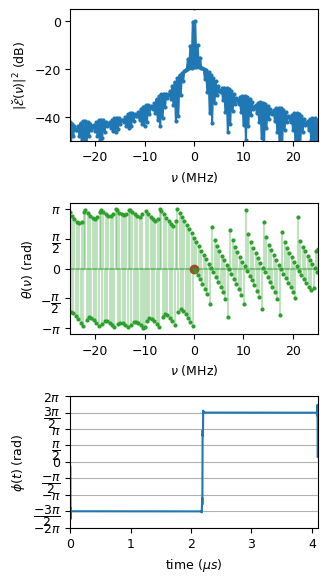

In [4]:
if __name__ == "__main__":
    '''Instructions to use:
    As an example, the script can be run as-is.
    Ultimately, the phase that needs to be imprinted using an EOM is 'phase_t' in the 'results' dictionary

    To modify the constraints, make changes to the functions:
        make_constraints_frequency_domain
        make_constraints_time_domain

    Parameters that you shuld customise in phase_finder include
        sample_rate
        samples_per_cycle
        iterations

    To visualise more of the data, you can adjust the limits in
        plot_achieved_results

    '''

    data_file_name = 'arb_sideband_data.pkl'
    phase_finder(data_file_name)
    plot_achieved_results(data_file_name)